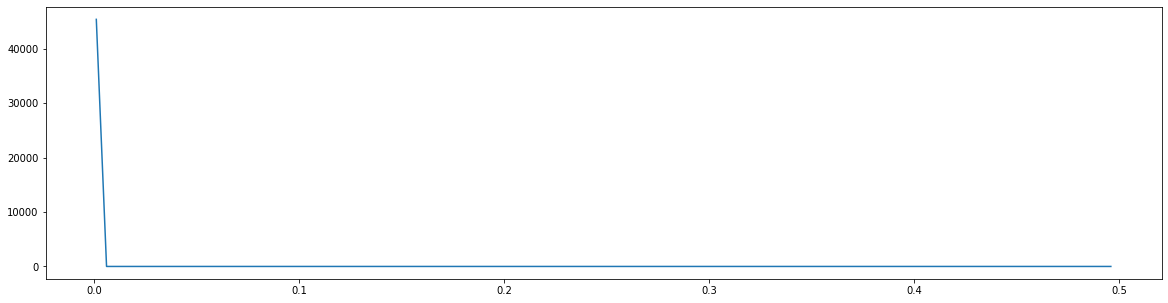

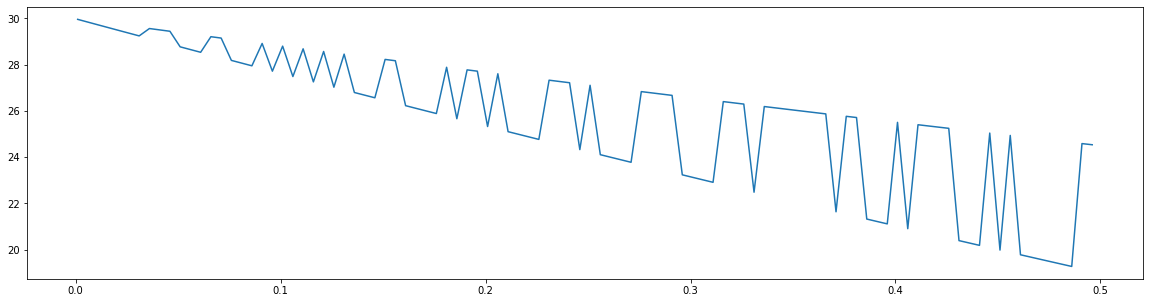

In [9]:
import sys
import os
import glob
sys.path.append('../../..')

from model import processing
# price_list = processing.import_binance_prices(assets=['USDC'], start_date='Jul 23 2022', days=200)
# print(price_list[0:10])

from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, price, usd_price, dynamicadd_asset_fee, dynamicadd_lrna_fee, cash_out_omnipool
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, back_and_forth, trade_to_slippage, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

assets = {
    'USDC': {'usd price': 1, 'weight': 0.5},
    'HDX': {'usd price': 0.5, 'weight': 0.5}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

states = [
    GlobalState(
        pools={
            'omnipool': OmnipoolState(
                tokens={
                    tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
                },
                preferred_stablecoin='USDC',
                # oracles={'fee_raise': 50},  # , 'fee_lower': 7200},
                lrna_fee=0,
                asset_fee=0,
            )
        },
        agents={
            'Trader': Agent(
                holdings={tkn: 1000000000 for tkn in list(assets.keys()) + ['LRNA']},
                trade_strategy=trade_to_slippage(pool_id='omnipool', slippage=0.005, trade_chance=1)
            ),
        },
        external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
        archive_all = False
    ),
    GlobalState(
        pools={
            'omnipool': OmnipoolState(
                tokens={
                    tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
                },
                preferred_stablecoin='USDC',
                # oracles={'fee_raise': 50},  # , 'fee_lower': 7200},
                lrna_fee=0,
                asset_fee=0,
            )
        },
        agents={
            'Trader': Agent(
                holdings={tkn: 1000000000 for tkn in list(assets.keys()) + ['LRNA']},
                trade_strategy=price_sensitive_trading(pool_id='omnipool', max_volume_usd=10, price_sensitivity=50, trade_frequency=1)
            ),
        },
        external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
        archive_all = False
    )
]

trade_volume = {}
for state in states:
    trade_volume[state] = []
    for i in range(100):
        state.pools['omnipool'].lrna_fee = i / 1000 + 0.001
        state.pools['omnipool'].asset_fee = i / 200 + 0.001
        events = run.run(state.copy(), time_steps=2, silent=True)
        trade_volume[state].append(sum(events[-1].pools['omnipool'].volume_in.values()) + sum(events[-1].pools['omnipool'].volume_out.values()))

for state in states:
    plt.figure(figsize=(20, 5))
    plt.plot([i / 200 + 0.001 for i in range(100)], trade_volume[state])


In [2]:
# lines = []
# with open('./output/test_results_static_fees_dec.txt', 'r') as file:
#     data = file.readlines()
#     lines = [float(line [10: 20]) for line in list(filter(lambda line: line[0] == 'r', data))]
    
# print(len(lines))
# print(lines)
# test_results = [lines[i * 10: i * 10 + 10] for i in range(10)]

In [3]:
# print(test_results[0])

In [5]:
print(trade_volume[states[0]][1])

30364.248546067625


In [ ]:
for tkn in initial_state.pools['omnipool'].asset_list:
    ax=pu.plot(events[::20], asset=tkn)
    pu.plot(events[::20], pool='omnipool', prop='usd_price', key=tkn, subplot=ax)

In [ ]:
plt.figure(figsize=(20, 5))
from model.amm.omnipool_amm import cash_out_omnipool
plt.plot(range(len(events[::20])), [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events[::20]])

In [ ]:
import copy
ordered_results = copy.copy(test_results)
ordered_results.sort(key=lambda x: x[2])
pprint([result[:3] for result in ordered_results])

In [ ]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].asset_fee=0.025
basic_state.pools['omnipool'].lrna_fee=0.005

basic_events = run.run(basic_state, time_steps=time_steps)


In [ ]:
ax=pu.plot(basic_events[::20], asset='ETH')
pu.plot(basic_events[::20], pool='omnipool', prop='usd_price', key='ETH', subplot=ax)

In [ ]:
plt.figure(figsize=(20, 5))
LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in basic_events[::20]]


plt.plot(range(len(LP_holdings)), LP_holdings)


In [ ]:
print([result[1] for result in test_results])
plt.figure(figsize=(20, 5))
plt.plot([result[1] for result in test_results], [sum(result[3]) * result[1] for result in test_results])
# plt.yscale('log')

In [ ]:
plt.figure(figsize=(20, 5))
LP_holdings1 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events[::20]]
LP_holdings2 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events2[::20]]
LP_holdings3 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events3[::20]]

plt.plot(range(len(LP_holdings1)), LP_holdings1)
plt.plot(range(len(LP_holdings2)), LP_holdings2)
plt.plot(range(len(LP_holdings2)), LP_holdings3)
plt.title('basic fees (blue) vs best tested parameters (orange) vs worst tested parameters (green)')

In [ ]:
print(test_results[1])



In [ ]:
random.seed(42)
basic_state2 = initial_state.copy()
basic_state2.pools['omnipool'].asset_fee=0.0025
basic_state2.pools['omnipool'].lrna_fee=0.0005

events4=run.run(basic_state2, time_steps=time_steps)
LP_holdings4 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events4[::20]]


In [ ]:
random.seed(42)
basic_state3 = initial_state.copy()
basic_state3.pools['omnipool'].asset_fee=0.0025
basic_state3.pools['omnipool'].lrna_fee=0.0005

events5=run.run(basic_state3, time_steps=time_steps)
LP_holdings5 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events5[::20]]


In [ ]:

print(LP_holdings1[-1])
print(LP_holdings2[-1])
print(LP_holdings3[-1])
print(LP_holdings4[-1])
print(LP_holdings5[-1])


In [ ]:
# print(events[0], events[1000])

In [ ]:
print(winning_state, losing_state)

In [ ]:
pu.plot(events, asset='DOGE')

In [ ]:
ax = pu.plot(events, pool='omnipool', oracle='fee_raise', prop='volume_in', key='DOT')
pu.plot(events2, pool='omnipool', oracle='fee_raise', prop='volume_in', key='DOT', subplot=ax)

In [ ]:
print(test_results[0])
print(test_results[-1])

In [ ]:
volume_out_usd = [event.pools['omnipool'].oracles['fee_raise'].price['USD'] for event in events3]
plt.plot(range(len(volume_out_usd)), volume_out_usd)

In [ ]:
reverse_price_list = list(reversed(processing.import_binance_prices(assets=['DOT', 'ETH', 'BTC', 'DOGE'], start_date='Nov 1 2022', days=30)))
reverse_basic_state = initial_state.copy()
reverse_basic_state._evolve_function=historical_prices(reverse_price_list)
reverse_basic_events = run.run(reverse_basic_state, time_steps = time_steps)

reverse_state = reverse_basic_state.copy()
reverse_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
    minimum=0.0005,
    amplification=test_results[-1].lrna_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[-1].lrna_decay,
    fee_max=test_results[-1].lrna_max,
)
reverse_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
    minimum=0.0025,
    amplification=test_results[-1].asset_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[-1].asset_decay,
    fee_max=test_results[-1].asset_max,
)
reverse_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (test_results[-1].oracle_length + 1)
reverse_events = run.run(reverse_state, time_steps = time_steps)

worst_reverse_state = reverse_state.copy()
worst_reverse_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
    minimum=0.0005,
    amplification=test_results[0].lrna_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[0].lrna_decay,
    fee_max=test_results[0].lrna_max,
)
worst_reverse_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
    minimum=0.0025,
    amplification=test_results[0].asset_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[0].asset_decay,
    fee_max=test_results[0].asset_max,
)
worst_reverse_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (test_results[-1].oracle_length + 1)
worst_reverse_events = run.run(worst_reverse_state, time_steps = time_steps)


In [ ]:
reverse_LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in reverse_events[::20]]
worst_reverse_LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in worst_reverse_events[::20]]
reverse_basic_LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in reverse_basic_events[::20]]
plt.figure(figsize=(20, 5))
plt.plot(range(len(reverse_LP_holdings)), reverse_basic_LP_holdings)
plt.plot(range(len(reverse_LP_holdings)), reverse_LP_holdings)
plt.plot(range(len(reverse_LP_holdings)), worst_reverse_LP_holdings)
plt.title('basic fees (blue) vs best tested parameters (orange) vs worst tested parameters (green) with price movement reversed')

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(price_list)), [price_list[i]['ETH'] for i in range(len(price_list))])
plt.plot(range(len(price_list)), [reverse_price_list[i]['ETH'] for i in range(len(price_list))])
plt.title('two different, opposite price runs')

In [ ]:
pu.plot(reverse_events, asset='ETH')

In [ ]:
pu.plot(reverse_events[::100], agent='Trader', prop='holdings', key='ETH')

In [ ]:
oracle = [event.pools['omnipool'].oracles['fee_raise'].volume_in['ETH'] for event in reverse_events][:100]
plt.plot(range(len(oracle)), oracle)

In [ ]:
pu.plot(reverse_events[::20], pool='omnipool', prop='last_fee')
pu.plot(reverse_events[::20], pool='omnipool', prop='last_lrna_fee')

pu.plot(events2[::20], pool='omnipool', prop='last_fee')
pu.plot(events2[::20], pool='omnipool', prop='last_lrna_fee')


In [ ]:
print('hi')


In [ ]:
print(events2[0])


In [ ]:
no_archive_state = basic_state.copy()
no_archive_state.archive_all = True
short_events_1 = run.run(no_archive_state, time_steps = 1)
short_events_2 = run.run(no_archive_state, time_steps = 1)
short_events_3 = run.run(no_archive_state, time_steps = 1)
short_events_4 = run.run(no_archive_state, time_steps = 1)


In [ ]:
print(repr(short_events_1[0]) == repr(short_events_2[0]))
print(short_events_1[0])
print(short_events_2[0])
# state1 = repr(short_events_1[0])
# state2 = repr(short_events_2[0])
# for i, char in enumerate(state1):
#     if char != state2[i]:
#         print(char)
